100%|██████████| 2.64G/2.64G [02:03<00:00, 21.4MB/s]


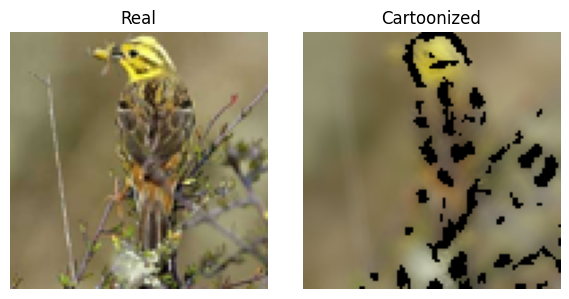

In [2]:
# 📦 Imports
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import cv2

# 🎨 Cartoonizer function
def cartoonize(img_tensor):
    img = img_tensor.permute(1, 2, 0).numpy()
    img = (img * 255).astype(np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur = cv2.medianBlur(gray, 5)
    edges = cv2.adaptiveThreshold(blur, 255,
                                  cv2.ADAPTIVE_THRESH_MEAN_C,
                                  cv2.THRESH_BINARY, 9, 9)
    color = cv2.bilateralFilter(img, 9, 300, 300)
    cartoon = cv2.bitwise_and(color, color, mask=edges)
    return cartoon

# 📥 Load CIFAR-10 (250 samples)
transform = transforms.ToTensor()
full_dataset = datasets.STL10(root='./data', split='train', download=True, transform=transform)
subset = torch.utils.data.Subset(full_dataset, range(250))
real_loader = DataLoader(subset, batch_size=1, shuffle=False)

# 🧪 Process images
real_imgs = []
cartoon_imgs = []

for img, _ in real_loader:
    img = img.squeeze()  # [3, 32, 32]
    real_imgs.append(img)
    cartoon = cartoonize(img)
    cartoon_tensor = transforms.ToTensor()(cartoon)
    cartoon_imgs.append(cartoon_tensor)

real_imgs = torch.stack(real_imgs)
cartoon_imgs = torch.stack(cartoon_imgs)

# 🏷️ Labels
real_labels = torch.zeros(len(real_imgs), dtype=torch.long)
cartoon_labels = torch.ones(len(cartoon_imgs), dtype=torch.long)

X = torch.cat([real_imgs, cartoon_imgs], dim=0)
y = torch.cat([real_labels, cartoon_labels], dim=0)

# 🧾 Dataset and DataLoader
dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# 👀 Visual check
def show_real_vs_cartoon(index=0):
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].imshow(real_imgs[index].permute(1, 2, 0))
    axs[0].set_title("Real")
    axs[0].axis('off')

    axs[1].imshow(cartoon_imgs[index].permute(1, 2, 0))
    axs[1].set_title("Cartoonized")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

# Try it
show_real_vs_cartoon(0)


In [5]:
# 🔁 Tiny CNN from before
class TinyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 24 * 24, 64)  # Changed from 8x8 to 24x24 for 96x96 input
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))     # → [B, 16, 48, 48]
        x = self.pool(F.relu(self.conv2(x)))     # → [B, 32, 24, 24]
        x = x.view(-1, 32 * 24 * 24)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 🔧 Init model, loss, optimizer
model = TinyCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

from torch.utils.data import random_split

# 👇 Split into 80% train / 20% test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

# 📊 Training loop
for epoch in range(10):
    running_loss = 0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    print(f"Epoch {epoch+1}: Loss={running_loss:.4f}, Accuracy={acc:.2f}%")

# 🧪 Evaluate on test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"\n🔍 Test Accuracy: {100 * correct / total:.2f}%")


Epoch 1: Loss=8.9135, Accuracy=56.00%
Epoch 2: Loss=6.5915, Accuracy=74.00%
Epoch 3: Loss=3.5136, Accuracy=93.25%
Epoch 4: Loss=1.6686, Accuracy=95.00%
Epoch 5: Loss=0.7147, Accuracy=98.25%
Epoch 6: Loss=0.4071, Accuracy=99.25%
Epoch 7: Loss=0.1840, Accuracy=100.00%
Epoch 8: Loss=0.0992, Accuracy=100.00%
Epoch 9: Loss=0.0536, Accuracy=100.00%
Epoch 10: Loss=0.0407, Accuracy=100.00%

🔍 Test Accuracy: 96.00%
